# Business As Usual

This section of the notebook uses a bootstrap approach to model the distribution of potential ecosystem service outcomes (i.e., amount of ecosystem services acquired as fields are fallowed) that can be expected with the amount of fallowing required to meet SGMA targets per region, as defined by [Medellin-Azuara, Josue et al. (2019). Water and the Future of the San Joaquin Valley, Technical Appendix C: Potential Economic Impacts of Reducing Water Use on San Joaquin Valley Agriculture. Public Policy Insitute of California.](https://www.ppic.org/publication/water-and-the-future-of-the-san-joaquin-valley/)

Results are saved in tabular format for the region evaluated in the outputs/ directory of this project folder.  

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# User-specified inputs
region_code = 'KR'

<hr></hr>

In [3]:
# Input from 010-data-prep
df = pd.read_csv('../outputs/df_' + region_code +'.csv')

In [4]:
# Path to output, use as input to future notebooks
outname = '../outputs/' + 'trials_' + region_code +'.csv'

In [5]:
targets = pd.read_csv('../data/targets.csv', index_col='region', thousands=',')
targets

,alfalfa-pasture,corn,field-crops-grains,veg-fruits,trees-vines
region,,,,,
NW,21320.0,8400.0,85920.0,3880.0,3880.0
NE,56850.0,7750.0,23580.0,2260.0,16800.0
SW,36820.0,3880.0,72350.0,8400.0,7750.0
SE,38760.0,16150.0,124030.0,650.0,9690.0
KR,88500.0,54910.0,42640.0,3230.0,11630.0


### Model Business as Usual Case

In [6]:
df.columns

Index(['FID', 'Area', 'Crop', 'FieldCropPrice', 'SavedWater', 'Recharge',
       'Kitfox', 'TiptonKRat', 'GiantGarterSnake', 'TNC', 'HabCorridors',
       'ConservationAreas', 'ImpBirdAreas', 'Nitrate', 'ModSAGBI',
       'Prox2Wetlands', 'Depth2GroundWater', 'Crop_PPIC', 'PricePerAcre',
       'SavedWater_Norm', 'Recharge_Norm', 'Depth2GroundWater_Norm',
       'Kitfox_Total', 'TiptonKRat_Total', 'GiantGarterSnake_Total',
       'TNC_Total', 'HabCorridors_Total', 'ConservationAreas_Total',
       'ImpBirdAreas_Total', 'Nitrate_Total', 'ModSAGBI_Total',
       'Prox2Wetlands_Total', 'Depth2GroundWater_Norm_Total'],
      dtype='object')

In [7]:
#Get list of columns to track for each repetition
outcome_cols = ['Area', 'FieldCropPrice', 'SavedWater_Norm', 'Recharge_Norm', 'Kitfox_Total',
                'TiptonKRat_Total', 'GiantGarterSnake_Total', 'TNC_Total', 'HabCorridors_Total',
                'ConservationAreas_Total', 'ImpBirdAreas_Total', 'Nitrate_Total', 'ModSAGBI_Total',
                'Prox2Wetlands_Total', 'Depth2GroundWater_Norm_Total'] 

In [8]:
# specify region, list of crop types, and list of ecosystem service outcomes to track
# set up dataframe to store outcomes of each trial
# for 1000 tries:
#    set up master df (shape = 0 x number of columns of df)
#    for crop in crop type:
#        subset dataset, get target, check that sufficient area is available
#        randomly sort the df
#        subset to meet target
#        append to master df
#    calculate total ecosystem services accumulated and acres faLLowed in master df
#    append outcomes to trials dataframe

crop_types = targets.columns
trials = pd.DataFrame(columns=outcome_cols)

for i in range(100):
    df_fallow = pd.DataFrame(columns=df.columns)
    for crop in crop_types:
        df_crop = df[df['Crop_PPIC'] == crop]
        target = targets.loc[region_code, crop]
        df_crop_shuffle = df_crop.sample(n=df_crop.shape[0])
        df_crop_shuffle.sort_values('PricePerAcre', inplace=True)
        # Identify fields up to target
        df_fallow_bool = df_crop_shuffle['Area'].cumsum() < target
        # Get one additional field by updating value from False to True where 
        # first instance of False is located
        if not df_fallow_bool[df_fallow_bool!=True].empty:
            index = df_fallow_bool[df_fallow_bool!=True].index[0]
            df_fallow_bool.at[index]=True        
        df_crop_fallow = df_crop_shuffle[df_fallow_bool]
        df_fallow = df_fallow.append(df_crop_fallow, ignore_index=True)
    outcomes = pd.DataFrame(df_fallow[outcome_cols].sum()).T
    areas = df_fallow[['Area','Crop_PPIC']].groupby('Crop_PPIC').sum().T
    areas.reset_index(drop=True, inplace=True)
    output = pd.concat([outcomes, areas], axis=1, sort=False)
    trials = trials.append(output, ignore_index=True, sort=False)

In [9]:
trials.head(10)

,Area,FieldCropPrice,SavedWater_Norm,Recharge_Norm,Kitfox_Total,TiptonKRat_Total,GiantGarterSnake_Total,TNC_Total,HabCorridors_Total,ConservationAreas_Total,ImpBirdAreas_Total,Nitrate_Total,ModSAGBI_Total,Prox2Wetlands_Total,Depth2GroundWater_Norm_Total,alfalfa-pasture,corn,field-crops-grains,trees-vines,veg-fruits
0,156569.188779,2.516832e+08,28517.871307,17533.714758,156422.402804,138078.328436,51348.832680,25132.401278,4249.589956,107355.316965,32820.867619,118789.739492,63443.301842,86458.973612,117267.562199,75261.390188,23740.216326,42640.013696,11697.495433,3230.073137
1,156654.344175,2.518378e+08,28525.283516,17397.972079,156507.558199,138166.707045,51099.679632,26091.069855,4117.862698,107015.102502,33401.290769,118857.763064,63902.025355,87529.276980,117607.701510,75261.390188,23740.216326,42715.983447,11692.823273,3243.930941
2,156753.544211,2.519511e+08,28532.798384,17476.139050,156606.758235,138302.509487,51690.783708,25784.554819,3779.534489,107003.324601,32617.747137,118780.786442,63181.502816,89007.091122,117159.930254,75261.390188,23740.216326,42816.028087,11679.643863,3256.265747
3,156606.942536,2.519895e+08,28518.992154,17430.338296,156460.156561,136994.618632,51220.422023,25973.988494,4015.975231,107060.906758,32993.493162,118674.304430,63905.384358,87800.750739,117814.929825,75261.390188,23740.216326,42650.464731,11662.431949,3292.439343
4,156527.052312,2.513693e+08,28506.026634,17498.346986,156380.266337,137375.272173,51090.108161,26046.665054,4250.298330,107652.991022,33769.724211,118533.435194,63471.527767,88205.845363,117165.282561,75261.390188,23740.216326,42655.708096,11631.036858,3238.700845
5,156698.508353,2.517114e+08,28526.755679,17490.217350,156551.722377,137929.981058,51560.469720,25543.943769,4320.719071,106195.528250,32715.903293,118500.757917,63094.629349,87666.670998,117811.554312,75261.390188,23740.216326,42787.941309,11677.219557,3231.740973
6,156612.956993,2.519060e+08,28522.461553,17586.419835,156466.171018,137259.484307,50643.527869,25072.631092,4437.201956,106994.765986,32685.364690,118575.824082,63298.395753,86237.983313,117888.180601,75261.390188,23740.216326,42658.978577,11695.722514,3256.649389
7,156561.894649,2.516547e+08,28513.345824,17548.600236,156415.108674,137591.694240,50364.161458,25320.890308,4232.296763,106924.649008,33126.846388,118775.131433,62706.707188,87176.853354,117550.060441,75261.390188,23740.216326,42646.731927,11660.374382,3253.181826
8,156784.342798,2.527726e+08,28539.908402,17487.295354,156637.556822,137816.005177,51329.454192,25547.255451,4058.195247,107695.579946,33363.641819,119471.091481,63240.321096,87551.683114,116870.220493,75261.390188,23740.216326,42735.529333,11683.889656,3363.317296
9,156569.739548,2.515773e+08,28514.009927,17361.426818,156422.953572,138451.825405,51709.773354,25588.735699,4368.730209,107015.995569,33169.977601,119135.720754,63502.668386,87884.598191,117615.445217,75261.390188,23740.216326,42665.157135,11664.260982,3238.714918


#### Save output

In [10]:
trials.to_csv(outname)

### Visualize results

#### Compare to PPIC Report

In [11]:
# Average revenue loss
value = trials['FieldCropPrice'].mean()
print (f'${value:,.2f}')

$251,770,570.94


#### Ensure sufficient acreage fallowed

In [12]:
# Bar chart with each crop type on x-axis, acreage fallowed as bars, and targets as dots. Visualize difference between
# acreage fallowed and target for each crop type in one chart.

C:\Users\Erik\Anaconda3\lib\site-packages\seaborn\distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


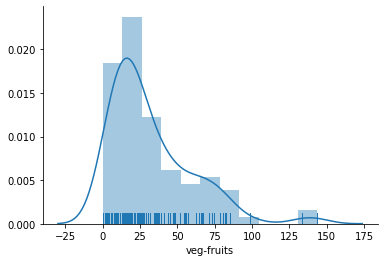

In [14]:
crop_type = 'veg-fruits'
sns.distplot(trials[crop_type]-targets.loc[region_code, crop_type], rug=True)
sns.despine()

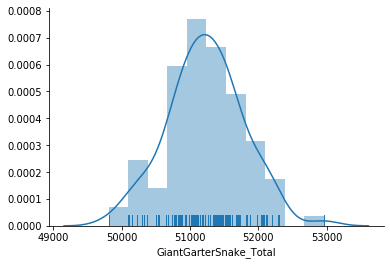

In [15]:
sns.distplot(trials['GiantGarterSnake_Total'], rug=True)
sns.despine()

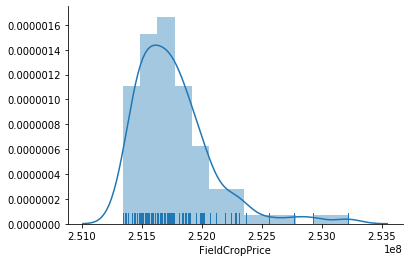

In [16]:
sns.distplot(trials['FieldCropPrice'], rug=True)
sns.despine()